In [21]:
import pandas
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
from torchvision import datasets
import torchvision.transforms as T
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [22]:
# Importer Un data préfait (MNIST)

training_datasets = datasets.CIFAR10(
    root="data",
    train= True,
    download = True,
    transform= T.ToTensor()
)

test_datasets = datasets.CIFAR10(
    root="data",
    train= False,
    download = True,
    transform= T.ToTensor()

)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
print(training_datasets)
print(training_datasets.data.shape)
print("target", type(training_datasets.targets))
print(len(training_datasets.targets))

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
(50000, 32, 32, 3)
target <class 'list'>
50000


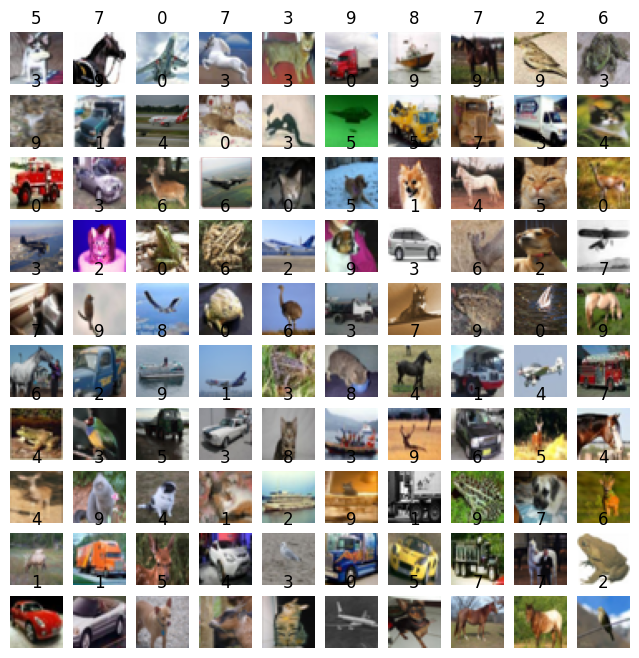

In [24]:

figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 10
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_datasets), size=(1,)).item()
    img, label = training_datasets[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.permute(1,2,0))
plt.show()


In [25]:
from torch.utils.data import DataLoader

batch_size = 64

training_dataloader = DataLoader(training_datasets, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_datasets, batch_size=batch_size)

for X, y in test_dataloader:
    print(f'shape X : {X.shape}')
    print(f'y shape : {y.shape}')
    break

shape X : torch.Size([64, 3, 32, 32])
y shape : torch.Size([64])


In [26]:
train_features, train_labels = next(iter(training_dataloader))  
train_features.shape

torch.Size([64, 3, 32, 32])

# Normalisation

In [27]:
import torch
import numpy
import torchvision.datasets as datasets
from torchvision import transforms

imgs = [item[0] for item in training_datasets] # item[0] and item[1] are image and its label
imgs = torch.stack(imgs, dim=0).numpy()

# calculate mean over each channel (r,g,b)
mean_r = imgs[:,0,:,:].mean()
mean_g = imgs[:,1,:,:].mean()
mean_b = imgs[:,2,:,:].mean()
print(mean_r,mean_g,mean_b)

# calculate std over each channel (r,g,b)
std_r = imgs[:,0,:,:].std()
std_g = imgs[:,1,:,:].std()
std_b = imgs[:,2,:,:].std()
print(std_r,std_g,std_b)

0.49139968 0.48215827 0.44653124
0.24703233 0.24348505 0.26158768


In [28]:
# Importer Un data préfait (MNIST)

training_dataset_v2 = datasets.CIFAR10(
    root="data",
    train= True,
    download = True,
    transform= T.Compose([T.ToTensor(), T.Normalize(([mean_b,mean_g, mean_r]), ([std_b,std_g, std_r]))])
)    

test_dataset_v2 = datasets.CIFAR10(
    root="data",
    train= False,
    download = True,
    transform= T.Compose([T.ToTensor(), T.Normalize(([mean_b,mean_g, mean_r]), ([std_b,std_g, std_r]))]) 

)

Files already downloaded and verified
Files already downloaded and verified


In [29]:
# Mean, Variance des images
from torch.utils.data import ConcatDataset

mean, std = 0, 0

combined_data = ConcatDataset([training_dataset_v2, test_dataset_v2])

for image, label in combined_data:
    image = image.view(32*32*3)
    mean+= image.mean().sum()
    std += image.std().sum()

mean/=len(combined_data)
std/=len(combined_data)

print(f'mean : {mean:.4f}')
print(f'std: {std:.4f}')

mean : -0.0012
std: 0.8525


In [30]:
from torch.utils.data import DataLoader

batch_size = 64

training_dataloader = DataLoader(training_dataset_v2, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset_v2, batch_size=batch_size)

for X, y in test_dataloader:
    print(f'shape X : {X.shape}')
    print(f'y shape : {y.shape}')
    break

shape X : torch.Size([64, 3, 32, 32])
y shape : torch.Size([64])


In [31]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [32]:
from torch.utils.tensorboard import SummaryWriter

In [33]:


writer = SummaryWriter('runs/mnist_experiment_1')
def train_loop(dataloader, model, loss_fn, optimizer, batch_size):
    model.train()
    epoch_loss = 0
    correct = 0
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        epoch_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return epoch_loss / len(dataloader), correct / len(dataloader.dataset) * 100

def test_loop(dataloader, model, loss_fn):
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    return test_loss / len(dataloader), correct / len(dataloader.dataset) * 100

# Training loop with added graphing
def train_and_test(dataloader_train, dataloader_test, model, loss_fn, optimizer, epochs, batch_size):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train the model
        train_loss, accuracy = train_loop(dataloader_train, model, loss_fn, optimizer, batch_size)
        writer.add_scalars('Loss', {'train': train_loss}, epoch)
        writer.add_scalars('Accuracy', {'train': accuracy}, epoch)

        # Test the model
        test_loss, accuracy = test_loop(dataloader_test, model, loss_fn)
        writer.add_scalars('Loss', {'test': test_loss}, epoch)
        writer.add_scalars('Accuracy', {'test': accuracy}, epoch)

        print(f"Epoch {epoch+1}/{epochs} complete\n")


In [34]:
import torch.nn as nn
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN,self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )        
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*16*16, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 10),
        )
    def forward(self, x):
        x = self.conv_stack(x)
        x = self.mlp(x)
        return x

In [35]:
cnn = CNN().to(device)
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=1e-3)



In [ ]:
writer = SummaryWriter('runs/mnist_experiment_2')
train_and_test(training_dataloader, test_dataloader, cnn, loss_fn, optimizer, 10, batch_size)

Epoch 1/10


In [ ]:
cnn.to('cpu')
torch_input = torch.randn(3,3,32,32)

onnx_program = torch.onnx.export(
    cnn,
    torch_input,
    'model.onnx',
    verbose=True,
    input_names=['input'],
    output_names = ['output'],
    opset_version=11,
    export_params=True,
    do_constant_folding=True,
    dynamic_axes={
        "input": {0: "batch_size"},
        "output" : {0 : "batch_size"}
    }
)   

In [ ]:
import onnxruntime

onnx_input = [torch_input]
print(f"Input length: {len(onnx_input)}")
print(f"Sample input: {onnx_input}")

ort_session = onnxruntime.InferenceSession("./model.onnx", providers=['CPUExecutionProvider'])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

onnxruntime_input = {k.name: to_numpy(v) for k, v in zip(ort_session.get_inputs(), onnx_input)}

# onnxruntime returns a list of outputs
onnxruntime_outputs = ort_session.run(None, onnxruntime_input)[0]

In [ ]:
torch_outputs = cnn(torch_input)

assert len(torch_outputs) == len(onnxruntime_outputs)
for torch_output, onnxruntime_output in zip(torch_outputs, onnxruntime_outputs):
    torch.testing.assert_close(torch_output, torch.tensor(onnxruntime_output))

print("PyTorch and ONNX Runtime output matched!")
print(f"Output length: {len(onnxruntime_outputs)}")
print(f"Sample output: {onnxruntime_outputs}")